In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


In [3]:
train = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv')
test = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv')

train.head()
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           40000 non-null  int64  
 1   airline      35387 non-null  object 
 2   flight       40000 non-null  object 
 3   source       40000 non-null  object 
 4   departure    35208 non-null  object 
 5   stops        37681 non-null  object 
 6   arrival      40000 non-null  object 
 7   destination  40000 non-null  object 
 8   class        40000 non-null  object 
 9   duration     36987 non-null  float64
 10  days_left    35562 non-null  float64
 11  price        40000 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 3.7+ MB


In [4]:
# Filling missing values with mode  or mean 
train.fillna(train.mode().iloc[0], inplace=True)
test.fillna(test.mode().iloc[0], inplace=True)

# Map class column
train['class'] = train['class'].map({'Economy': 0, 'Business': 1})
test['class'] = test['class'].map({'Economy': 0, 'Business': 1})

# Map stops column
stops_map = {
    'zero': 0, 'one': 1, 'two': 2, 'three': 3,
    'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3,
    'two_or_more': 2
}
train['stops'] = train['stops'].map(stops_map)
test['stops'] = test['stops'].map(stops_map)


In [5]:
train.drop_duplicates(inplace=True)


Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
train = train[(train['price'] >= lower) & (train['price'] <= upper)]


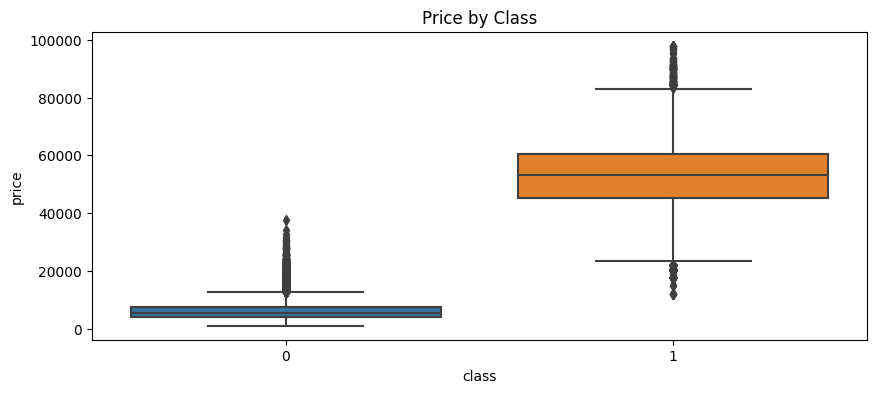

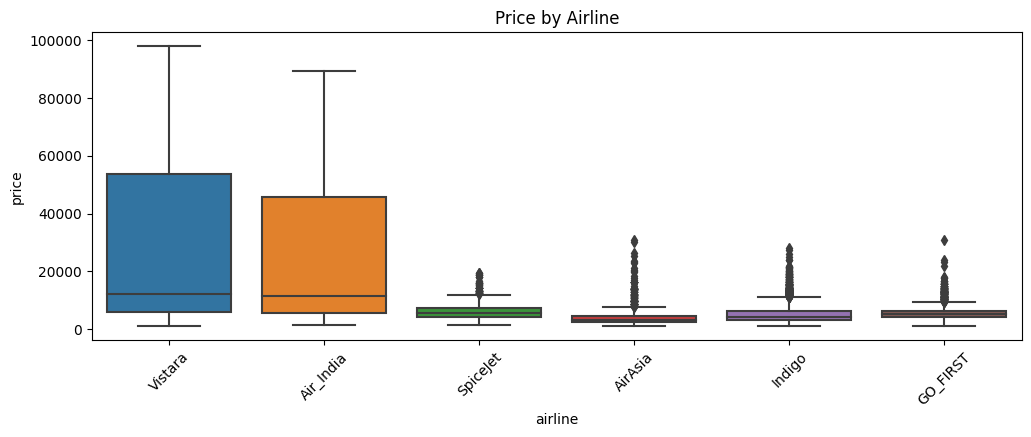

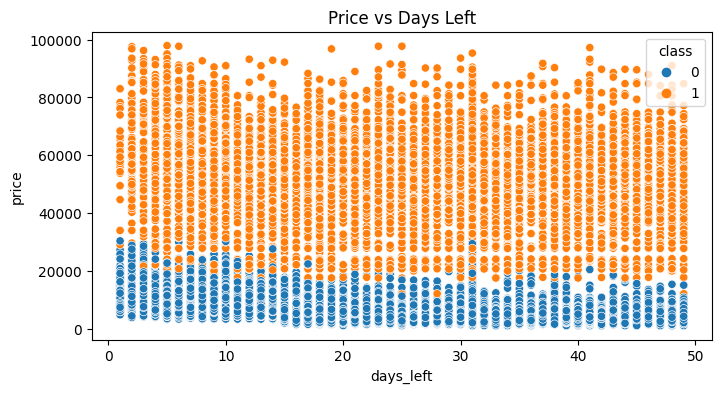

In [6]:
plt.figure(figsize=(10,4))
sns.boxplot(x='class', y='price', data=train)
plt.title("Price by Class")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x='airline', y='price', data=train)
plt.xticks(rotation=45)
plt.title("Price by Airline")
plt.show()

plt.figure(figsize=(8,4))
sns.scatterplot(x='days_left', y='price', hue='class', data=train)
plt.title("Price vs Days Left")
plt.show()


In [7]:
X = train.drop(['id', 'price'], axis=1)
y = train['price']
X_test = test.drop('id', axis=1)


In [8]:
categorical = ['airline', 'flight', 'source', 'departure', 'arrival', 'destination']
numerical = ['duration', 'days_left', 'stops', 'class']

num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical),
    ('cat', cat_pipeline, categorical)
])


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
from xgboost import XGBRegressor


In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, verbosity=0)
}

results = []

for name, model in models.items():
    
    try:
        pipe = make_pipeline(preprocessor, model)
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        results.append((name, rmse))
        print(f"{name} RMSE: {rmse:.2f}")
    except Exception as e:
        print(f" Error training {name}: {e}")

Linear Regression RMSE: 6455.21
Decision Tree RMSE: 4318.15
Random Forest RMSE: 3470.54
Gradient Boosting RMSE: 5219.16
KNN RMSE: 4220.78
SVR RMSE: 25379.65
XGBoost RMSE: 5210.49


In [12]:
from sklearn.model_selection import GridSearchCV

# Gradient Boosting Tuning
gb_params = {
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__max_depth': [3, 5],
    'gradientboostingregressor__learning_rate': [0.05, 0.1]
}

gb_pipe = make_pipeline(preprocessor, GradientBoostingRegressor())
gb_grid = GridSearchCV(gb_pipe, gb_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)
print("Best GB RMSE:", -gb_grid.best_score_)
print("Best GB Params:", gb_grid.best_params_)


Best GB RMSE: 4270.4010176883285
Best GB Params: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__n_estimators': 200}


In [13]:
# Random Forest Tuning
rf_params = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_depth': [None, 10]
}

rf_pipe = make_pipeline(preprocessor, RandomForestRegressor())
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best RF RMSE:", -rf_grid.best_score_)
print("Best RF Params:", rf_grid.best_params_)


Best RF RMSE: 3671.256705407816
Best RF Params: {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 100}


In [14]:
# XGBoost Tuning
xgb_params = {
    'xgbregressor__n_estimators': [100, 200],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__learning_rate': [0.05, 0.1]
}

xgb_pipe = make_pipeline(preprocessor, XGBRegressor(verbosity=0))
xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("Best XGB RMSE:", -xgb_grid.best_score_)
print("Best XGB Params:", xgb_grid.best_params_)


Best XGB RMSE: 4296.8706331474805
Best XGB Params: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 200}


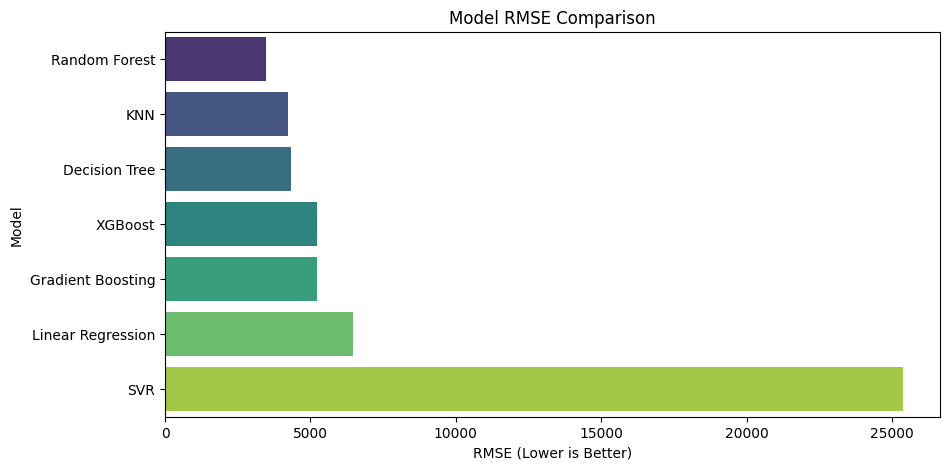

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame(results, columns=['Model', 'RMSE'])
results_df = results_df.sort_values(by='RMSE')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='RMSE', y='Model', palette='viridis')
plt.title('Model RMSE Comparison')
plt.xlabel('RMSE (Lower is Better)')
plt.ylabel('Model')
plt.show()


In [16]:

final_model = gb_grid.best_estimator_  
final_model.fit(X, y)  

#  Predicting on test data
final_preds = final_model.predict(X_test)

# submission
submission_df = pd.DataFrame({
    'id': range(len(final_preds)),
    'price': final_preds
})


submission_df.to_csv('submission.csv', index=False)